# MLB Spin Rate Analysis
If you follow baseball, you're well aware of what spin rate is by now due to all the recent buzz around it and its effect on pitcher performance. If you aren't familiar, spin rate is a measure of how much a baseball spins in revolutions per minute (RPM). The number of revolutions has a significant impact on how the ball behaves - pitches with a high spin rate will have a more dramatic shift in trajectory (think curveballs), while a lower spin rate can create more movement (change-ups, knuckleballs).

There has always been talk of "rising fastballs", <a href="https://tht.fangraphs.com/the-physics-of-a-rising-fastball/#:~:text=It%20appears%20as%20though%20the%20legend%20of%20the,pointed%20out%2C%20%E2%80%9CA%20fastball%20could%20rise%20in%20principle"> (and whether or not they are physically possible)</a>, but regardless of how the ball actually behaves, a high spin rate on a fastball can at minimum make a pitch to appear to rise near home plate, making it more difficult to hit. With the advent of Statcast, spin rate became easily measureable and it was understood that pitches with higher RPM had a <a href="https://www.drivelinebaseball.com/2016/11/spin-rate-what-we-know-now/">better chance of inducing a swinging strike.</a> However, as of 2016 nobody seemed to know (or claimed not to know) "how to reliably and consistently change the spin rate of pitchers."

Enter foreign substances - pitchers have long utilized rosin to get a better grip on the baseball, which is perfectly permissable as far as the MLB is concerned. Beyond that, according to Major League rule 8.02(a)(4) a pitcher may not apply a foreign substance to the ball. It was pretty well known though that most pitchers would occasionally apply pine tar, sunscreen, or other substances to get a better grip. In fact, when <a href="https://www.youtube.com/watch?v=k8UjLR5nvx0">Yadi had a pitch stick to his chestplate in 2017</a> everyone bascially turned a blind eye, and you could get away with violating the rule for the most part as long as you <a href="https://time.com/76468/yankees-pitcher-michael-pineda-suspended-for-pine-tar-incident/">weren't incredibly obvious.</a>

So what changed that has driven the MLB's crackdown on foreign substances? According to Statcast, the average fastball has been <a href="https://www.si.com/mlb/2021/06/04/sticky-stuff-is-the-new-steroids-daily-cover">dropping 2 inches less in 2021 than it did on its way to homeplate in 2018.</a> There have been 6 no hitters this year - 7 if you include combined - and we haven't reached the All-Star break. Strikeouts are up almost 5% from 2015 <a href="https://www.overtimeheroics.net/2021/04/30/2021-mlb-stats-strikeouts-rise/">across the league</a>. With batting averages at an all time low, and growing frustration from position players, the MLB decided to move quickly with <a href="https://www.espn.com/mlb/story/_/id/31572769/mlb-plans-enforcement-foreign-substance-rules-being-finalized-rollout-pending-sources-say">stricter enforcement of the foreign substances in early June.</a>

I decided to take a look for myself using pybaseball and it's access to Statcast data to explore the impact of this decision on average spin rates, and explore the degree to witch a few prominent pitchers have been affected.

## Data Loading and Exploration

In [1]:
import pybaseball
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

For the purpose of comparison, I wanted a sense of historical spin rates to understand how much they've changed in recent years, and how much they've declined since June. Using pybaseball's statcast method, we'll be looking at ~3.5M pitches from 2016-2021.

In [2]:
plt.style.use('seaborn')
#Import statcast data
full = pybaseball.statcast(start_dt='2016-01-01', end_dt='2021-12-31')
print(f'Total pitches in selected timeframe: {full.shape[0]}')

This is a large query, it may take a moment to complete


  0%|                                                                                         | 0/1210 [00:00<?, ?it/s]

Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates
Skipping offseason dates


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [10:27<00:00,  1.93it/s]


Total pitches in selected timeframe: 3562116


### Spin Rate Distrobutions
Different pitches have a different average spin rate - a good knuckleball should have almost no spin, while a curveball requires a high number of revolutions to create significant movement. 

Text(0.5, 1.0, 'Spin Rate Distrobutions by Pitch Type. Overall Mean: 2233')

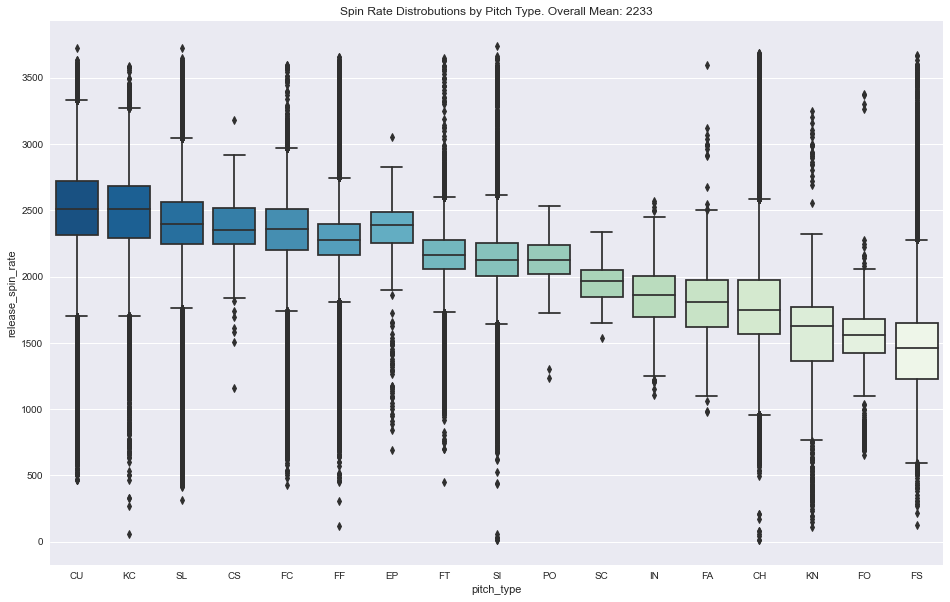

In [3]:
order_=full.groupby('pitch_type').agg({'release_spin_rate' : 'mean'}).sort_values(by='release_spin_rate', ascending=False).index
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.boxplot(x='pitch_type', y='release_spin_rate', data=full, ax=ax, palette='GnBu_r',
                order=order_)
ax.set_title(f'Spin Rate Distrobutions by Pitch Type. Overall Mean: {full.release_spin_rate.mean():.0f}')


The pitches with the highest median spin rate are Curveballs (CU) and Knucklecurves (KC), while the lowest are Changups (CH),  Knuckleballs (KN), Forkballs (FO), and Splitters (FS). For this analysis, I focused only on fastballs excl. Splitters (Four-Seam, Two-Seam, Sinkers, and Cutters) to be sure and remove any noise from trends. In other words, I wanted to be sure that any decrease in spin rate signals an actual change in pitcher performance, and is not related to a decrease in the number of curveballs or sliders they're throwing. 

In [4]:
#Filtering for Fastballs
fast_balls = full[full.pitch_type.isin(['FC', 'FT', 'SI', 'FF'])].copy()
fast_balls['pitch_year'] = [date.year for date in fast_balls.game_date]

### Spin Rate Correlation
To better understand how spin rate relates to a pitchers performance, lets take a look at how it correlates with a few pitching statistics since 2018:

- ERA: Earned Run Average
- K/BB: Strikeouts to Walk Ratio
- WHIP: Walks + Hits per Inning Pitching
- FIP: Fielder Independent Pitching
- SwStr%: Swinging Strike %
- K/9: Strikeouts per 9 Innings

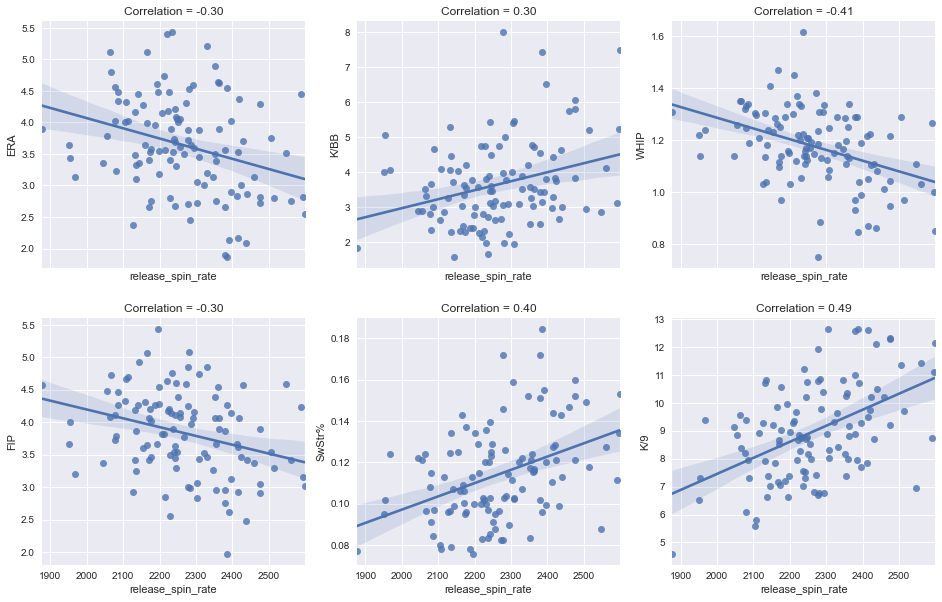

In [5]:
pitching_stats = pybaseball.pitching_stats(2018, 2021)
stats = pitching_stats.groupby('Name').mean().reset_index()
stats = stats[['Name', 'ERA', 'K/BB', 'WHIP', 'FIP', 'SwStr%', 'K/9']]

fast_balls['Name'] = fast_balls.player_name.apply(lambda x: x.split(", ")[1] + " " +x.split(", ")[0])
grouped = fast_balls[fast_balls.pitch_year >=2018].groupby('Name').agg({'release_spin_rate':'mean'})

g_df = grouped.merge(stats, on='Name', how='inner')
corr_ = g_df.corr()

fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=True)
stats_list = ['ERA', 'K/BB', 'WHIP', 'FIP', 'SwStr%', 'K/9']
for i, ax in enumerate(axes.flat):
    sns.regplot(x=g_df.release_spin_rate.astype(float), y=g_df[stats_list[i]].astype(float), data=g_df, ax=ax)
    ax.set_title(f"Correlation = {corr_.iloc[0][stats_list[i]]:.2f}")

Spin rate has a degree of correlation with all of the selected stats, however the most significant of the 6 are K/9 and SwStr% - in other words, the higher your spin rate, the better your chances are of striking out a batter. It follows that an increase in average spin rates across the board would contribute to the rise of the three true outcomes (HRs, BB, and K's), and that pitchers might turn to performance enhancing substances to drive up their spin rate. If the impacts of foreign substances are to be believed, a pitcher with an average spin rate of ~2100 could reasonably expect to increase their K/9 by 1-2 if they were able to increase spin rate by ~300 RPM. 

## YoY League Spin Rate Trends
Now that we have an understanding of how spin rate relates to pitcher performance, let's see how it has shifted over the past ~5 years. 

To explore and plot Statcast data, I defined a couple functions to calculate the moving average of spin rate across a selected window, and then plot the moving average by year. I've excluded the post-season as RPMs tend to shoot up during that time frame, and used a 15 day window for the league average. 

In [6]:
def m_avg_by_year(df, avg_window, year_column, group_col, agg_col, agg_measure):
    """Group Data by Year and calculate moving average to prevent data skewing YoY"""
    grouped = df.groupby(year_column)
    frames = []
    for name, data in grouped:
        avg_data = data.groupby(group_col).agg({agg_col : agg_measure}).dropna()
        avg_data['moving'] = avg_data.release_spin_rate.rolling(window=avg_window).mean()
        avg_data['graph_date'] = avg_data.index.strftime('%m-%d')
        avg_data['pitch_year'] = name
        avg_data.reset_index(inplace=True)
        frames.append(avg_data)
    return pd.concat(frames, ignore_index=True)

def plot_yoy_rate(df, window, player=None, cmap='ocean_r', 
                  lgnd = ['2016', '2017', '2018', '2019', '2020', '2021'],
                  year_column = 'pitch_year',
                  group_col = 'game_date', agg_col = 'release_spin_rate',
                  agg_measure = 'mean'):
    
    """Plots spin rate Data YoY on a shared axis"""
    if player:
        df = df[(df.player_name == player)]
    g = m_avg_by_year(df, window, year_column, group_col, agg_col, agg_measure)
    
    #Pivot for cleaner graphing, and exclude post-season dates
    graph_piv = pd.pivot_table(g[g.graph_date < '09-30'][['moving', 'pitch_year', 'graph_date']],
                        index=['graph_date'], columns=['pitch_year'], values=['moving'])
    
    #Populate NA values with last value - critical for individual players, fills All-Star Break for aggregate data
    graph_piv.fillna(method='ffill', inplace=True)
    graph_piv.loc[datetime.now().strftime('%m-%d'): , ('moving', 2021)] = np.nan
    
    #Return graph object
    ax = graph_piv.plot(colormap=cmap, figsize=(16,6))
    ax.legend(lgnd)
    ax.set_ylabel("Average Spin Rate")
    ax.set_xlabel("Date")
    return ax


Text(55, 2290, 'MLB signals crackdown\non foreign substances')

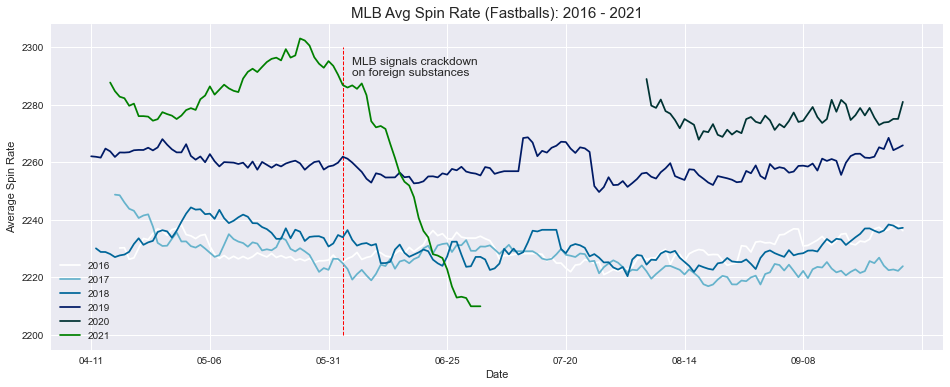

In [7]:
#Plot 15 day moving average of Spin rate 
ax = plot_yoy_rate(fast_balls, 15)
ax.set_title('MLB Avg Spin Rate (Fastballs): 2016 - 2021', fontsize=15)
ax.vlines(x=[53], ymin=2200, ymax=2300, colors='red', linestyles='dashed', linewidth=1)
ax.text(55, 2290, 'MLB signals crackdown\non foreign substances', fontsize=12)

It's clear there was an immediate, and dramatic decrease in spin rates following the announcement umpires would be checking for foreign substances. It seemsthere might have been some behind the scenes action or discussions as well given the average starts to drop even before the public announcement.

2019 seems to be the year when application of foreign substances might have seen increased adoption, as the average leaps ahead of the historical trend from 2016-2018. Interestingly, the average spin rate has not just dropped since May - it has plummeted to the lowest point in over 5 years. While the latest topic of conversation has been around substances like <a href="http://www.spidertack.com/">Spider Tack</a> (a substance strongmen use for lifting Atlas Stones), a byproduct of the enforcement could be decreased use of "classic" substances like pine tar or sunscreen used in the past. While used historically for grip or increased movement, whatever was being utilized appears to have been increasing spin rate as well. 

## Spin Rate by Pitcher
It appears that use of foreign substances to enhance spin rate is a pervasive issue - but how does that play out on an individual pitcher basis? Let's lets take a look at a few elite pitchers and to see who has experienced a decrease in spin rates, and who has been unaffected. 

In [8]:
def plot_player(data, window, player_list, player_idx):
    ax = plot_yoy_rate(data, window, player_list[player_idx])
    ax.set_title(f'Avg Spin Rate - {player_list[player_idx].split(", ")[1]} {player_list[player_idx].split(", ")[0]}',
                 fontsize=14)
    return ax

pitchers = [
           'Cole, Gerrit', 
           'Bauer, Trevor', 
           'deGrom, Jacob', 
           'Kershaw, Clayton',
           'Scherzer, Max', 
           'Darvish, Yu',
           'Hendricks, Kyle'
            ]

### Gerrit Cole

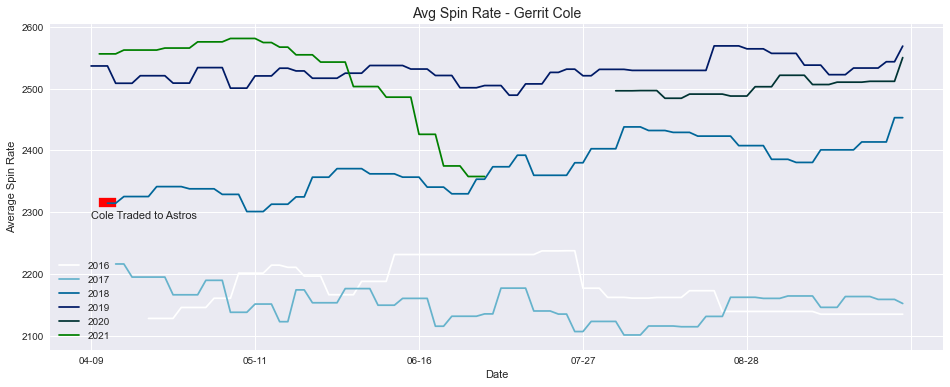

In [9]:
ax = plot_player(fast_balls, 3, pitchers, 0)
ax.text(0, 2290, 'Cole Traded to Astros', fontsize=11)
rect = plt.Rectangle((1, 2308), 2, 15, color='r', alpha=1)
ax.add_patch(rect)

In the 2018 offseason, Gerrit Cole was traded from the Pittsburgh Pirates to the Houston Astros and subsequently saw an insrease in his spin rate from ~2150 in 2017 to ~2450 by the end of 2018. Given the Astros are a team <a href="https://en.wikipedia.org/wiki/Houston_Astros_sign_stealing_scandal">known for cheating</a>, it would be no surprise if Cole's increase in spin rate was in some way attributable to the use of foreign substances.

Trevor Bauer more or less insinuated this in 2018 when <a href="https://www.cbssports.com/mlb/news/indians-pitcher-trevor-bauer-insinuates-theres-something-fishy-going-on-with-astros-pitchers-and-mlb-rules/">he tweeted sarcastically about teams trading for pitchers whose spin rate they believe they could increase with foreign substances.</a> In later exchanges with Lance McCullers Jr., he clarified that his complaint was not so much with the use of foreign substances, but the uneven playing field it creates due to the MLB's selective enforcement. 

Cole's 2018 spin rate climbed throughout the year, reaching averages of 2500+ from 2019 into 2021. He was the MLB strikeout leader in 2019 and ERA while he enjoyed the elevated spin rate, which has since dropped to 2018 levels. How much of Cole's recent performance is attributable to foreign substances remains to be seen, however it would appear that he may have been benefitting from their use.

### Trevor Bauer


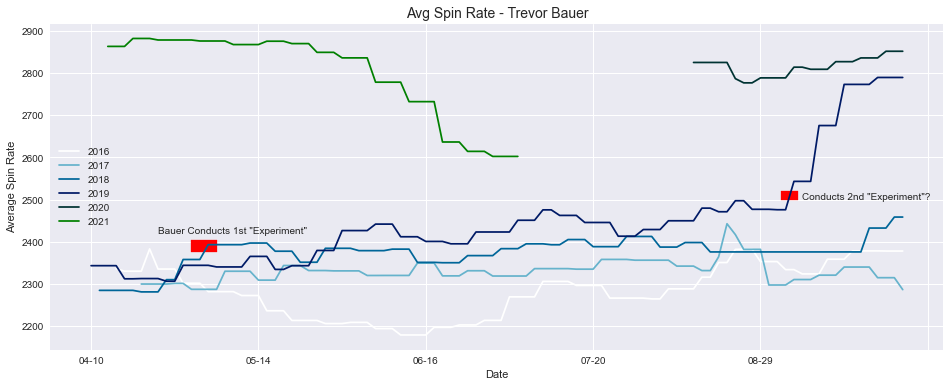

In [10]:
ax = plot_player(fast_balls, 3, pitchers, 1)
ax.text(8, 2420, 'Bauer Conducts 1st "Experiment"')
ax.text(85, 2500, 'Conducts 2nd "Experiment"?', fontsize=10)
rect1 = plt.Rectangle((82.5, 2500), 2, 20, color='r', alpha=1)
rect2 = plt.Rectangle((12, 2375), 3, 30, color='r', alpha=1)
ax.add_patch(rect1)
ax.add_patch(rect2)

Trevor Bauer has been outspoken about spin rates for a while, and at this point he's difficult to seperate from the topic. He has the current highest spin rate in the MLB, and has beleagured the topic for years - in his essay <a href="https://www.theplayerstribune.com/articles/trevor-bauer-cincinnati-reds-sign-stealing">"I wish I'd Been Wrong"</a> he mentions researching beginning in 2012, and stated "For eight years I’ve been trying to figure out how to increase the spin on my fastball because I’d identified it way back then as such a massive advantage. I knew that if I could learn to increase it through training and technique, it would be huge. But eight years later, I haven’t found any other way except using foreign substances."

He has <a href="https://www.youtube.com/watch?v=PLQk8_YpnE0">targeted the Astros as culprits of abusing foreign substances</a>, claiming they acquire players and make them superstars overnight, while noting that he would never use substances in game even though he knows the benefits. Yet in 2018, <a href="https://twitter.com/MLBastian/status/991703575955898368?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E991703575955898368%7Ctwgr%5E%7Ctwcon%5Es1_c10&ref_url=https%3A%2F%2Fwww.cbssports.com%2Fmlb%2Fnews%2Fa-look-at-trevor-bauers-history-of-discussing-foreign-substances-on-baseballs-and-increasing-spin-rate%2F">Bauer seemed to experiment with using substances as his spin rate jumped 200-300 RPMs</a> - the exact amount he claimed it would increase were he to use them. When questioned in a press conference about the jump, he had no comment. At the end of 2019, Bauer's spin rate skyrocketed - <a href="https://blogs.fangraphs.com/trevor-bauer-might-have-conducted-another-experiment/">without sacrificing spin efficiency</a> - and stayed that way through 2020 when he would win the Cy Young, before seeing a steep decline in 2021. Despite the recent trend, Bauer's spin rate remains the highest in the league.

Bauer's claim that he is morally above doctoring baseballs is more than ironic given recent news that have made his <a href="https://bleacherreport.com/articles/2945445-trevor-bauer-placed-on-mlb-administrative-leave-amid-sexual-assault-allegations">future in the MLB uncertain.</a> However, Bauer's outspokenness has solidified him as a key part of the discussion around spin rate - whether or not that will be only historically speaking remains to be seen. 

### Jacob deGrom

<bound method Axes.legend of <AxesSubplot:title={'center':'Avg Spin Rate - Jacob deGrom'}, xlabel='Date', ylabel='Average Spin Rate'>>

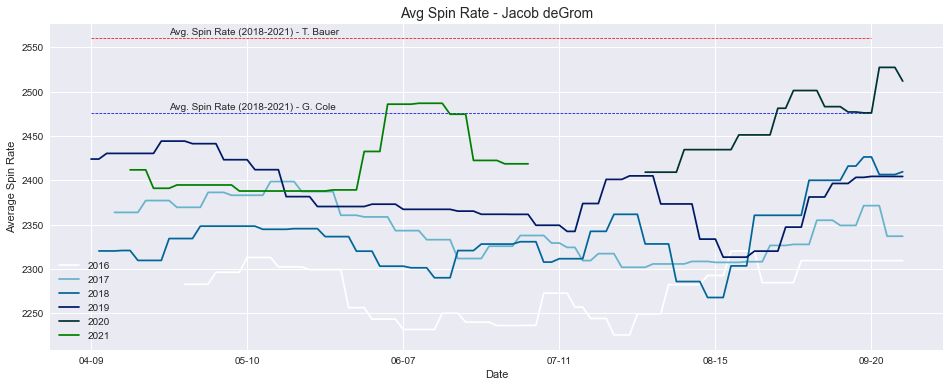

In [11]:
ax = plot_player(fast_balls, 3, pitchers, 2)
ax.hlines(y=fast_balls[(fast_balls.player_name == 'Bauer, Trevor') & (fast_balls.pitch_year.isin([2018,2019,2020,2021]))].release_spin_rate.mean(),
          xmin=0, xmax=100, colors='red', linestyles='dashed', linewidth=.75)
ax.hlines(y=fast_balls[(fast_balls.player_name == 'Cole, Gerrit') & (fast_balls.pitch_year.isin([2018,2019,2020,2021]))].release_spin_rate.mean(),
          xmin=0, xmax=100, colors='blue', linestyles='dashed', linewidth=.75)
ax.text(10, 2565, 'Avg. Spin Rate (2018-2021) - T. Bauer')
ax.text(10, 2480, 'Avg. Spin Rate (2018-2021) - G. Cole')
ax.legend(['2016', '2017', '2018', '2019', '2020', '2021'],loc='lower left')
ax.legend


Jacob deGrom is a 2 time Cy Young winner, who could reasonably be expected to win his third this year. As of writing this, his ERA is 0.95 and his WHIP is 0.54. He has accounted for 6 RBIs himself, while only allowing 9 ERs on the season. In short, <a href="https://www.pitcherlist.com/is-jacob-degrom-actually-good/">he's insanely talented.</a> One might expect a player that dominate to have seen a similar decrease in RPMs, yet his spin rate does not seem to have been as impacted by the rule enforcement - it actually went up at the same time that others declined. Additionally, his spin rate for the past 5 years has been well below Bauer's average, and mostly below Cole. 

While it's possible that deGrom may use some foreign substance, so far it seems as though his performance doesn't depend on it and I wouldn't expect to see much of a decline in his spin rate or performance going forward. (Good news for both the sanctity of baseball, and my Fantasy Team)

### Remaining Pitchers

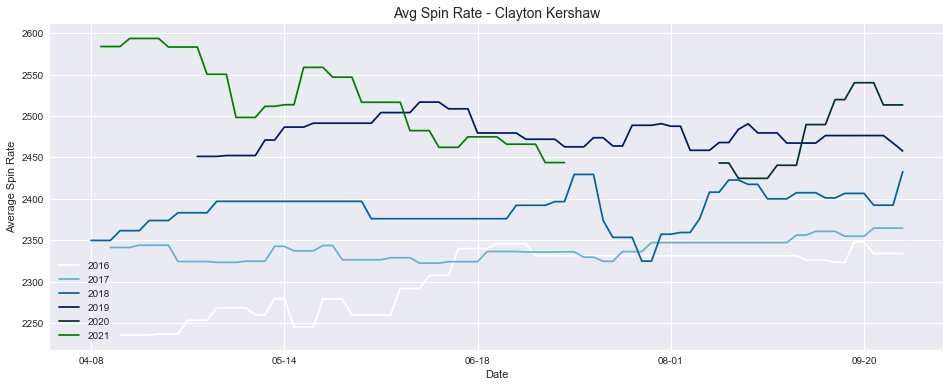

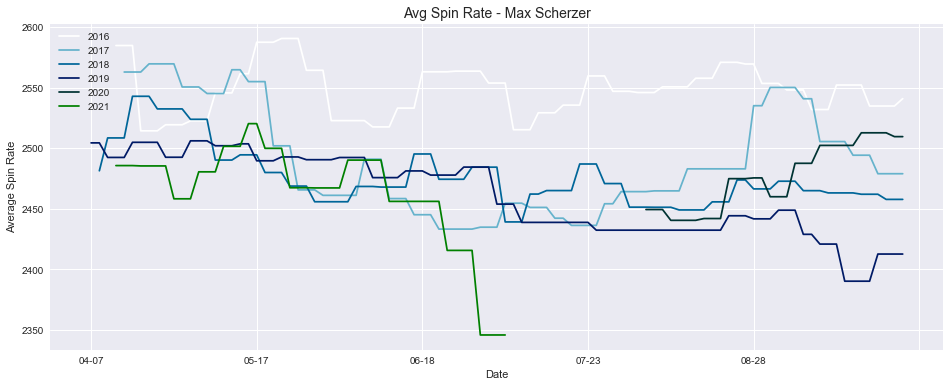

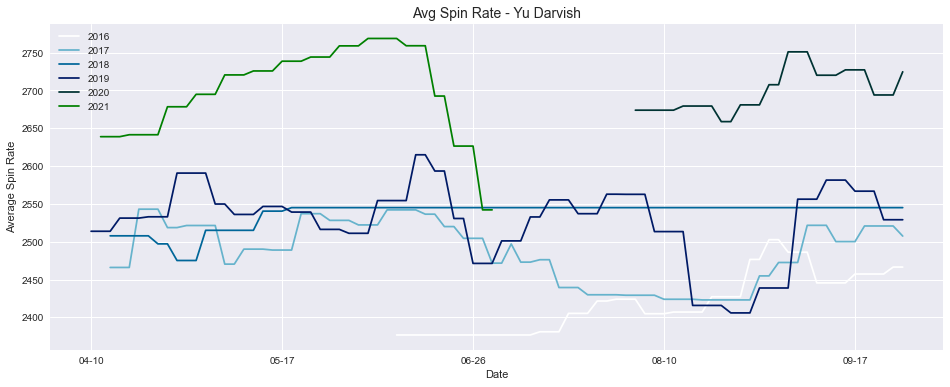

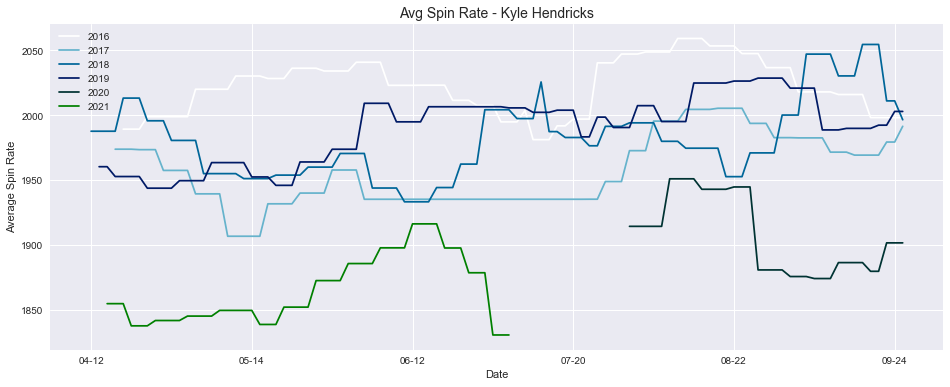

In [12]:
for pitcher in range(3,7):
    plot_player(fast_balls, 3, pitchers, pitcher)

An examination of the YoY trends for Kershaw, Scherzer, Darvish, and Hendricks reveals a similar pattern accross the board - a material decrease in spin rate in 2021. Darvish and Kershaw appear to have been experiencing higher spin rates compared to hisorical averages, while Scherzer and Hendricks saw already low rates drop even further. Regardless of the rate relative to past years, it would appear that all are experiencing an impact as a result of the increased speculation on foreign substances. 

## Conclusion
The league average spin rate reached an all time high in 2021 - something that seems to have been driven by an increased understanding of spin rate's impact on performance, and an uptick in the adoption of foreign substance use. An immediate decrease in average RPMs following the MLB's announcement they would be cracking down on substance use all but confirms the suspicion that adoption of foreign substance use was nearly ubiquitous. 

We will see in the coming months the impact that decreased spin rates has on pitchers' stats, and the game as a whole. The MLB has <a href="https://www.espn.com/mlb/story/_/id/30863022/mlb-slightly-deadening-baseball-amid-years-long-home-run-surge">taken steps this year to stymie the recent surge in HR's ,</a> and it will be interesting to see how a potential decrease in pitcher dominance plays out. Someone with a love for small ball might hope that there's a chance for offensive performance to increase, while the prevalence of three true outcomes declines. 